This notebook follows one notebook about SqueezeNet modified to medical images. It is not about model but only about loss. I add a L2 regularization to see if it prevents overfit. Honestly, the original models doesn't overfit, so I expect the regularization shouldn't affect a lot to our results. 

In [1]:
import glob, pylab, pandas as pd
import numpy as np

from __future__ import print_function, division
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from skimage import io, transform
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision import transforms, utils
import pydicom


import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda')
dtype = torch.float32 

import warnings
warnings.filterwarnings("ignore")


/home/minh/anaconda3/envs/dl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
!ls ../Data/all/

dog_cat				     stage_2_test_images.zip
GCP Credits Request Link - RSNA.txt  stage_2_train_images
stage_2_detailed_class_info.csv      stage_2_train_images.zip
stage_2_sample_submission.csv	     stage_2_train_labels.csv
stage_2_test_images


In [3]:
info_dir='stage_2_detailed_class_info.csv'
image_dir='stage_2_train_images'

In [4]:
df = pd.read_csv('../Data/all/'+info_dir)
df.head()

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [5]:
df.describe()

patientId                         class
count                                  30227                         30227
unique                                 26684                             3
top     ee820aa5-4804-4984-97b3-f0a71d69702f  No Lung Opacity / Not Normal
freq                                       4                         11821

In [6]:
df=df.replace(["No Lung Opacity / Not Normal","Normal"],0)
df=df.replace(["Lung Opacity"],1)
df.rename(columns={'class': 'Target'},inplace=True)
df.head()

patientId  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd       0
2  00322d4d-1c29-4943-afc9-b6754be640eb       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5       0
4  00436515-870c-4b36-a041-de91049b9ab4       1

Let's show one image.

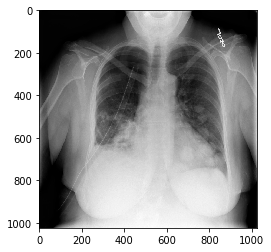

In [7]:
patient0=df.patientId[0]
patient0_file='../Data/all/'+image_dir+'/%s.dcm' % patient0
image0_data = pydicom.read_file(patient0_file)
image0 = image0_data.pixel_array
pylab.imshow(image0, cmap=pylab.cm.gist_gray)

I would like to load and process data in order to prepare for training a neural network. I start with the simplest process where there is neither transfromation nor augemetation to data.

In [8]:
class PneuDataset(Dataset):
    """Pneunomia dataset."""

    def __init__(self, FileName_data, img_dir, transform=None):
        """
        Args:
            FileName_data: Data frame with filenames of images.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = FileName_data
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        patient=self.df.patientId[idx]
        patient_file = os.path.join(self.img_dir,patient)+'.dcm'
        image = pydicom.read_file(patient_file).pixel_array
        label=self.df.Target[idx]
        
        if self.transform:
            image=self.transform(image)
        
        image = np.expand_dims(image, axis=0)
        
        return image, label

The following function is used to check accuracy on validation set. It simply calculates the rate of correct predition over total validation test.

In [9]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            loss = F.cross_entropy(scores, y)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f), and loss %.4f' % (num_correct, num_samples, 100 * acc, loss.item()))

In [10]:
def train(model, optimizer, epochs=1):
    """
    Train a model.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            loss = F.cross_entropy(scores, y)
  
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if (t+e*len(loader_train)) % print_every == 0:
                print('Iteration %d, epoch %d, loss = %.4f' % (t, e, loss.item()))
                check_accuracy(loader_val, model)
                print()

Now let's train the first model which contains only 2 convolutional layers with ReLU activation and a fully connected net at the last layer. We can play with all parameters like channels, sizes of convolution,...

We are ready to train our model. Here it is:

I will implement a transformation to dataset and re-train the model above. I implement only two transformation: a resizing, flipping, and their combination. 

In [11]:

#Transform an image
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        
        if isinstance(self.output_size, int):
            new_h, new_w=self.output_size, self.output_size 
        else:
            new_h, new_w = self.output_size

        img = transform.resize(image, (new_h, new_w))

        return img

class Flip(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):
        image = np.fliplr(image)
        return image
    

I will load one pretrained model and modify some layers, then train the modified model. I choose the squeezenet because of its simpleness. 

In [12]:
squeezenet = models.squeezenet1_0()

I would like to check all layers of the SqueezeNet. So I print each layer out.

In [13]:
child_counter = 0
for child in squeezenet.children():
   print(" child", child_counter, "is:")
   print(child)
   child_counter += 1

 child 0 is:
Sequential(
  (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (3): Fire(
    (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace)
  )
  (4): Fire(
    (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace)
  )
  (5): Fire(
    (squeeze): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation):

SqueezeNet reduces the number of parameters by two techniques: replace big convolution by $1\times 1$ convolution layers which is called squeeze step; reduce the number of channels corresponding to the big convolution. For the tradeoff issue complexity-accuracy, it says that if we reduce the complexity we pay by also reduce the accuracy. So to maintain the accuracy they postpone the downsample late in the network. 

So instead of using a conventional convolution layer, for example $3\times 3$-size, they replace it by a so called fire layer consisting of one queezed stage and one expanded stage, the squeezing reduces the number of input channels, and the expanding recovers the output channel but by two blocks, one with $1\times 1$ convolution and the rest with $3 \times 3$. 

Let's look at one layer to illustrate for the above analysis. If we, for example, use a $3\times 3$ convolution layer to treat the input $55\times 55\times 96$ with the output $55\times 55\times 128$ we have $(3\times 3\times 3\times 96+1)\times 128 = 110720$ parameters. Now we first use a $1\times 1$ convolution to reduce the input channel 96 down to 16, then a $1\times 1$ one to cover 96 output channels and a $3\times 3$ one to complement the rest 96 output channels, we finally get the same dimention output, but the number of parameters is $(1\times 1\times 96+1)\times 16+(1\times 1\times 16+1)\times 64+(3\times 3\times 16+1)\times 64=11920$, 9 times smaller.

So as listed, SqueezeNet is:
convolution -> MaxPool -> (fire) $\times 3$ -> Maxpool -> (fire) $\times 4$ -> MaxPool -> fire -> Dropout -> convolution -> AvgPool

Now I would like to adopt SqueezeNet to my problem. I start with the smallest modification: input channel of the first layer. Because my image is not BRG but only one channel. I will also resize image to $224\times 224$ and add one fully connected layer to get 2 scores since we have only 2 classes.

In [13]:
conv1=nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2))
child0=list(squeezenet.children())[0]
fire=child0[1:]
child1=list(squeezenet.children())[1]
child11=child1[1:-1]

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

model_modified=nn.Sequential(
    conv1,
    fire,
    child11,
    nn.Conv2d(1000, 96, kernel_size=(3, 3), stride=(1, 1),padding=1),
    Flatten(),
    nn.Linear(13*13*96,2)
    )

Let's check again our model's architecture.

In [15]:
child_counter = 0
for child in model_modified.children():
   print(" child", child_counter, "is:")
   print(child)
   child_counter += 1

 child 0 is:
Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2))
 child 1 is:
Sequential(
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (3): Fire(
    (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace)
  )
  (4): Fire(
    (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace)
  )
  (5): Fire(
    (squeeze): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activa

I will train the new model with a bigger sample. Let's check 500 samples with 400 training ones and 100 for validation.

In [14]:
FileName_500=df[:500]
img_dir='../Data/all/'+image_dir
dataset_transformed=PneuDataset(FileName_data=FileName_500, img_dir=img_dir, transform=Rescale(224))

train_size = 400
val_size = 100

train_dataset_500, val_dataset_500 = torch.utils.data.random_split(dataset_transformed, [train_size, val_size])

loader_train = DataLoader(train_dataset_500, batch_size=4,
                        shuffle=True)

loader_val = DataLoader(val_dataset_500, batch_size=4,
                        shuffle=True)

In [17]:
FileName_500[FileName_500.Target==1].count()

patientId    225
Target       225
dtype: int64

In [15]:
device='cuda'
learning_rate = 1e-3
print_every=500


optimizer = optim.SGD(model_modified.parameters(), lr=learning_rate, weight_decay=1e-4,
                     momentum=0.9, nesterov=True)

train(model_modified, optimizer,epochs=100)

Iteration 0, epoch 0, loss = 0.6920
Got 57 / 100 correct (57.00), and loss 0.6948

Iteration 0, epoch 5, loss = 0.6975
Got 57 / 100 correct (57.00), and loss 0.6507

Iteration 0, epoch 10, loss = 0.6503
Got 57 / 100 correct (57.00), and loss 0.6977

Iteration 0, epoch 15, loss = 0.7402
Got 57 / 100 correct (57.00), and loss 0.7398

Iteration 0, epoch 20, loss = 0.6532
Got 57 / 100 correct (57.00), and loss 0.6510

Iteration 0, epoch 25, loss = 0.6832
Got 57 / 100 correct (57.00), and loss 0.6915

Iteration 0, epoch 30, loss = 0.1920
Got 80 / 100 correct (80.00), and loss 0.6575

Iteration 0, epoch 35, loss = 0.6964
Got 57 / 100 correct (57.00), and loss 0.6561

Iteration 0, epoch 40, loss = 0.7491
Got 57 / 100 correct (57.00), and loss 0.6006

Iteration 0, epoch 45, loss = 0.2267
Got 82 / 100 correct (82.00), and loss 0.5424

Iteration 0, epoch 50, loss = 0.4511
Got 83 / 100 correct (83.00), and loss 0.3443

Iteration 0, epoch 55, loss = 0.1040
Got 80 / 100 correct (80.00), and loss 0.

In [16]:
check_accuracy(loader_train, model_modified)

Got 354 / 400 correct (88.50), and loss 0.0476


In [17]:
img_dir='../Data/all/'+image_dir
dataset_full_transformed=PneuDataset(FileName_data=df, img_dir=img_dir, transform=Rescale(224))

loader_full = DataLoader(dataset_full_transformed, batch_size=4,
                        shuffle=True)

In [18]:
check_accuracy(loader_full, model_modified)

Got 22682 / 30227 correct (75.04), and loss 0.0620


In [101]:
len(df)

30227

In [19]:
torch.save(model_modified, 'Squeezenet_Kernel3_reg_100e_500Samples.pt')

In [20]:
data_size=len(df)
training_size = int(0.8*data_size)
test_size = data_size-training_size

train_size=int(0.8*training_size)
val_size=training_size-train_size

train_dataset, val_dataset, test_set = torch.utils.data.random_split(dataset_full_transformed, [train_size, val_size,test_size])

loader_train = DataLoader(train_dataset, batch_size=4,
                        shuffle=True)

loader_val = DataLoader(val_dataset, batch_size=4,
                        shuffle=True)

In [29]:
device='cuda'
learning_rate = 0.5e-4
print_every=1000

# def weights_init(m):
#     if isinstance(m, nn.Conv2d):
#         torch.nn.init.xavier_uniform(m.weight.data)
        
# model_modified.apply(weights_init)

optimizer = optim.SGD(model_modified.parameters(), lr=learning_rate,weight_decay=1e-4,
                     momentum=0.9, nesterov=True)

train(model_modified, optimizer,epochs=10)

Iteration 0, epoch 0, loss = 0.1375
Got 3931 / 4837 correct (81.27), and loss 0.5472

Iteration 1000, epoch 0, loss = 1.2294
Got 3937 / 4837 correct (81.39), and loss 0.1153

Iteration 2000, epoch 0, loss = 0.4265
Got 3933 / 4837 correct (81.31), and loss 0.1919

Iteration 3000, epoch 0, loss = 0.1732
Got 3947 / 4837 correct (81.60), and loss 0.1643

Iteration 4000, epoch 0, loss = 0.2451
Got 3933 / 4837 correct (81.31), and loss 0.0519

Iteration 164, epoch 1, loss = 0.4010
Got 3930 / 4837 correct (81.25), and loss 0.0730

Iteration 1164, epoch 1, loss = 0.3863
Got 3908 / 4837 correct (80.79), and loss 0.2133

Iteration 2164, epoch 1, loss = 0.1803
Got 3941 / 4837 correct (81.48), and loss 0.8016

Iteration 3164, epoch 1, loss = 0.4264
Got 3932 / 4837 correct (81.29), and loss 0.0032

Iteration 4164, epoch 1, loss = 0.0871
Got 3944 / 4837 correct (81.54), and loss 0.0092

Iteration 328, epoch 2, loss = 0.3982
Got 3924 / 4837 correct (81.12), and loss 0.0275

Iteration 1328, epoch 2, l

After 10 first epochs, 0.001 learning rate, we've got 79.84% accuracy. I check the accuracy for the test set.

In [23]:
loader_test = DataLoader(test_set, batch_size=4,
                        shuffle=True)

In [24]:
check_accuracy(loader_test, model_modified) #after 10 epochs, leraning_rate=0.001

Got 4747 / 6046 correct (78.51), and loss 1.3684


In [26]:
check_accuracy(loader_test, model_modified)#after 2 epochs, leraning_rate=0.0005, validation still around 80%

Got 4790 / 6046 correct (79.23), and loss 0.6866


In [28]:
check_accuracy(loader_test, model_modified)#after 10 epochs, leraning_rate=0.0001, validation around 80.5%

Got 4819 / 6046 correct (79.71), and loss 0.8705


In [30]:
check_accuracy(loader_test, model_modified)#after 10 epochs, leraning_rate=0.00005, validation around 80%

Got 4761 / 6046 correct (78.75), and loss 0.2415


As I expected, results don't change much when addinig regularization. However, longer train might lead to instable accuracy which would make our model works worse. So it would be a good idea to save all the training process and pick the model when the loss is most stable.